## Marketing Attribution Analysis


## Table of Contents
- [Introduction](#intro)
- [Customer Purchase Pattern](#purchase_pattern)
- [Cross-Channel Interaction](#cross_channel)
- [Attribution Modeling](#modeling)
- [Action Plans](#action_plans)


<a id='intro'></a>
### Introduction

The dataset is from an online beauty store in Germany, which includes customer journey from various marketing channels, and each customers' total purchase amount. 
The purpose of the analysis is to find out the most effective channel, in order to maximise the impact of our marketing cost spending.

### Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('attribution.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


In [4]:
df.drop_duplicates(inplace = True)
df[df.isnull()].count()

cookie              0
time                0
interaction         0
conversion          0
conversion_value    0
channel             0
dtype: int64

In [5]:
# handling time & date

from datetime import datetime, timedelta

df['time'] = pd.to_datetime(df['time'])

df['dayofweek'] = df['time'].dt.dayofweek
df['hour'] = df['time'].dt.hour

def week_number_of_month(date_value):
     return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1])
df['weekofmonth'] = df['time'].apply(week_number_of_month)

In [6]:
def week_eng(date_value):
    if date_value == 0:
        return "0_Mon"
    elif date_value == 1:
        return "1_Tue"
    elif date_value == 2:
        return "2_Wed"
    elif date_value == 3:
        return "3_Thu"
    elif date_value == 4:
        return "4_Fri"
    elif date_value == 5:
        return "5_Sat"
    else:
        return "6_Sun"

df['dayofweek'] = df['dayofweek'].apply(week_eng)

In [7]:
bins = [0,7,12,18,22,24]
labels = ['5_night', '1_morning', '2_afternoon','3_evening', '4_eve-night']
df['hour_group'] = pd.cut(df['hour'], bins, right = False, labels = labels)

df.head()

,cookie,time,interaction,conversion,conversion_value,channel,dayofweek,hour,weekofmonth,hour_group
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,1_Tue,13,1,2_afternoon
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,1_Tue,19,3,3_evening
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,1_Tue,15,4,2_afternoon
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,6_Sun,7,4,1_morning
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,1_Tue,9,1,1_morning


<a id='purchase_pattern'></a>
### Customer Behaviour Pattern

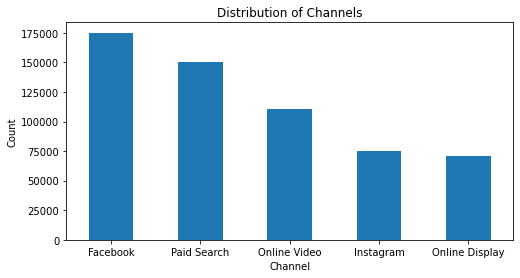

In [17]:
# What is the overall distribution of the different channels in your dataset? 
# Which channels are most prevalent, and which ones are less common?

channel_counts = df['channel'].value_counts()

plt.figure(figsize=(8, 4))
channel_counts.plot(kind='bar')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.title('Distribution of Interactions in Channels')
plt.xticks(rotation=0)
for i, value in enumerate(channel_counts):
    plt.text(i, value, f'{value:.2f}%', ha='center', va='bottom')
plt.show()

# 페이스북으로부터 유입량이 가장 많다. 

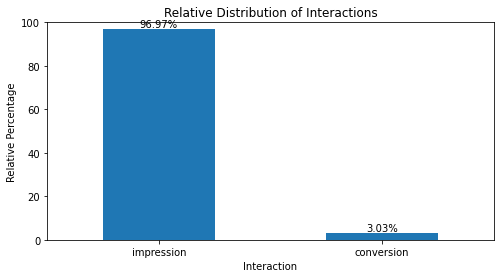

In [59]:
# What is the distribution of interactions (impressions and conversions) in the dataset? 

interaction_percentages = df['interaction'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 4))
interaction_percentages.plot(kind='bar')
plt.xlabel('Interaction')
plt.ylabel('Relative Percentage')
plt.title('Relative Distribution of Interactions')

total_interactions = interaction_percentages.sum()
for i, value in enumerate(interaction_percentages):
    plt.text(i, value, f'{value:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=0)
plt.ylim(0, 100) 
plt.show()

# 전체 유입량 중 3%만 전환한다

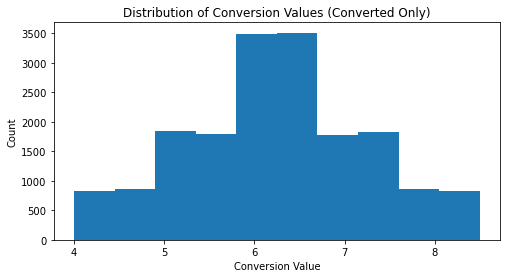

In [42]:
# What is the range and distribution of conversion values? 

conversion_data = df[df['conversion'] == 1]
plt.figure(figsize=(8, 4))
plt.hist(conversion_data['conversion_value'], bins=10)
plt.xlabel('Conversion Value')
plt.ylabel('Count')
plt.title('Distribution of Conversion Values (Converted Only)')
plt.show()


# 전환한 것들은 보통 6-7유로 사용. 아웃라이어는 없어보임

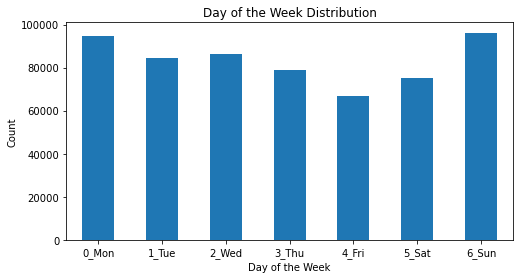

In [41]:
day_counts = df['dayofweek'].value_counts().sort_index()
plt.figure(figsize=(8, 4))
day_counts.plot(kind='line')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Day of the Week Distribution')
plt.xticks(rotation=0)
plt.show()

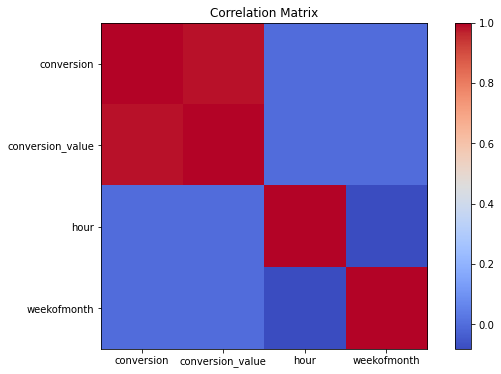

In [44]:
# Are there any relationships or correlations between different columns? 
# Do certain channels tend to have higher conversion values? Are conversions more common during specific hours of the day?

correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# specific time intervals that consistently show higher or lower interaction rates?

week_counts = df['weekofmonth'].value_counts().sort_index()
plt.figure(figsize=(8, 4))
week_counts.plot(kind='line')
plt.xlabel('Week of the Month')
plt.ylabel('Count')
plt.title('Interactions by Week of the Month')
plt.xticks(rotation=0)
plt.show()

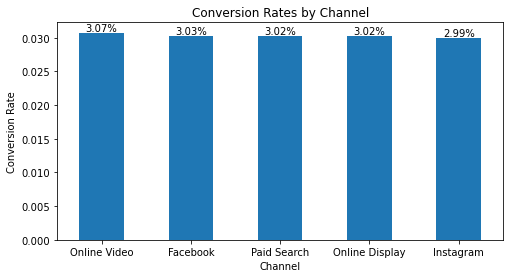

In [49]:
conversion_rates = df.groupby('channel')['conversion'].mean()
conversion_rates = conversion_rates.sort_values(ascending=False)

plt.figure(figsize=(8, 4))
conversion_rates.plot(kind='bar')
plt.xlabel('Channel')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Channel')
plt.xticks(rotation=0)

for index, value in enumerate(conversion_rates):
    plt.text(index, value, f'{value:.2%}', ha='center', va='bottom')

plt.show()

In [61]:
df['time'] = pd.to_datetime(df['time'])
cohort_group = df.groupby(df['cookie'].map(lambda x: x.split('_')[0]))
conversion_rate_by_cohort = cohort_group['conversion'].mean()
plt.figure(figsize=(8, 6))
conversion_rate_by_cohort.plot(kind='bar')
plt.xlabel('Cohort')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Cohort')
plt.xticks(rotation=0)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000223FB759B80> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# 내가 알고 싶은 것들을 종합해보자. 어떤 채널이 가장 사람들의 구매 의욕을 불러일으키느냐.
# 1) 전반적으로 어떤 채널이 가장 전환율이 높을까? 이때 전환율은 액션당임. 한 사람이 여러번 들어오면 여러번임.
# 동시에 어떤 채널이 가장 허수가 많을까? 100번 들어와도 1번 사는 거다. 즉 전환율이 낮은거다. 배너 보고 혹해서 들어왔는데 안사고 나가는 경우.
# 근데 3) 처럼 허수가 있대도 실제로 상품 질은 좋을 수 있음. 웹사이트가 문제일수도.

# 2) 특정 시간에 (혹은 특정 요일에) 특정 미디어를 사용할 때 더 전환율이 높을까? (더 구매의욕을 불러일으킬까?)

# 3) 만약 전환율을 액션당이 아니라 사람당이라고 하면 - 어떤 채널의 액션당 전환율은 낮은데 (10번 들어와도 2번 산다) 사람당 전환율은 높다면 (5명이 상품 페이지에 진입했는데 2명이 샀다)
# 중간에 결제 전에 방해하는 것이 있따는 것. 트래픽 기준 전환율과 사람 기준 전환율을 비교해보자.

# 4) 같은 광고를 한사람당 몇번을 봐야 한번 들어와볼 생각을 할까?

# 5) 어트리뷰션 윈도우 정리하자
# 6) 광고별 특성 정리하자

Instagram:

Visual-oriented platform primarily focused on sharing images and videos.
Popular among younger demographics, particularly millennials and Gen Z.
Engaging and interactive content formats such as Stories and IGTV.
Influencer marketing plays a significant role.
Users often discover new products and brands through Instagram.

Online Display:

Advertising banners or visuals displayed on websites and apps.
Broad reach across various websites and target audiences.
Can be effective for brand awareness and exposure.
Often used for retargeting campaigns to reach users who have shown interest.
Engagement rates can vary based on the design and placement of the ads.

Paid Search:

Advertising on search engines, such as Google Ads or Bing Ads.
Targeted based on keywords and user search queries.
Users actively searching for products or services.
High intent audience looking for specific information or solutions.
Effective for capturing users at the bottom of the marketing funnel.

Facebook:

Extensive user base with a wide range of demographics.
Diverse ad formats, including image ads, video ads, and carousel ads.
Advanced targeting options based on user interests, demographics, and behaviors.
Suitable for both brand awareness and direct response campaigns.
Strong emphasis on social interactions and user engagement.

Online Video:

Video advertising on platforms such as YouTube or streaming services.
High engagement and consumption of video content.
Can be used for various objectives, including brand awareness, storytelling, or product demonstrations.
Skippable and non-skippable ad formats available.
Popular among younger audiences and those who prefer video content.


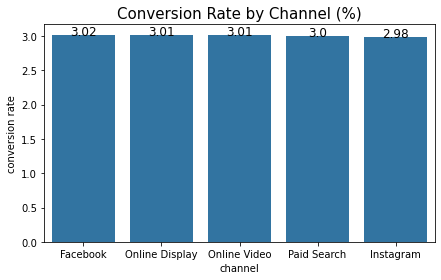

In [250]:
# (by Cohort)
## conversion rate per channel, time, day of week?
## conversion rate는 interaction 기준.

## 내가 알고 싶은 건. 어떤 채널은 5번 들어올 때 1번 사게 되겠지만, 또 다른 채널은 3번 들어올 때 1번 사게 될수도 있다. 이런 전환율

ch_con = round((df[df['conversion']==1].groupby('channel').size()*100/df.groupby('channel').size()),2).reset_index(name = 'conversion rate').sort_values(by = 'conversion rate', ascending = False)

colors = sns.color_palette()[0]
ax = sns.barplot(x = ch_con.channel, y = 'conversion rate', data = ch_con, color = colors)
ax.set_title("Conversion Rate by Channel (%)", size = 15)
ax.figure.set_size_inches(7,4)
for bar, label in zip(ax.patches, ch_con['conversion rate']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height, label, ha="center", size=12) ;


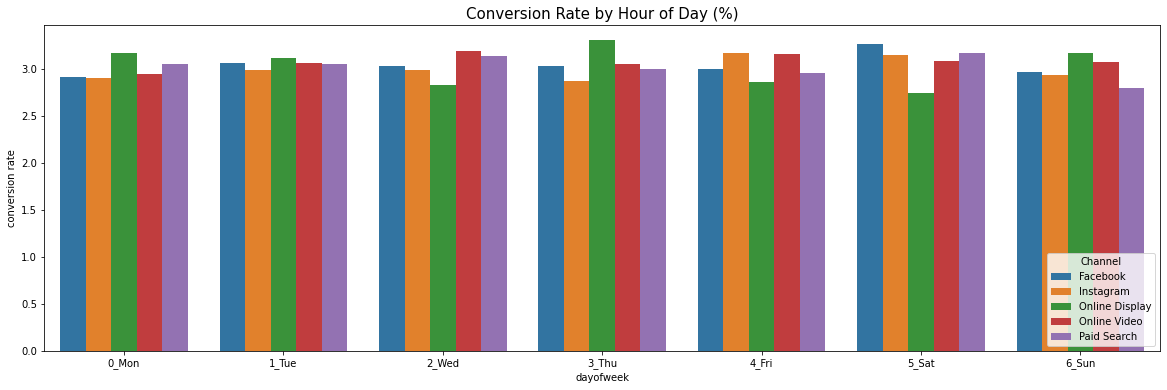

In [130]:
# 요일마다/ 시간마다 보는 미디어가 다를까?

ch_con = round((df[df['conversion']==1].groupby(['channel','dayofweek']).size()*100/df.groupby(['channel','dayofweek']).size()),2).reset_index(name = 'conversion rate')
ax = sns.barplot(hue='channel', y='conversion rate', x='dayofweek', data=ch_con)
ax.set_title("Conversion Rate by Hour of Day (%)", size=15)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0), title='Channel')

ax.figure.set_size_inches(20, 6)

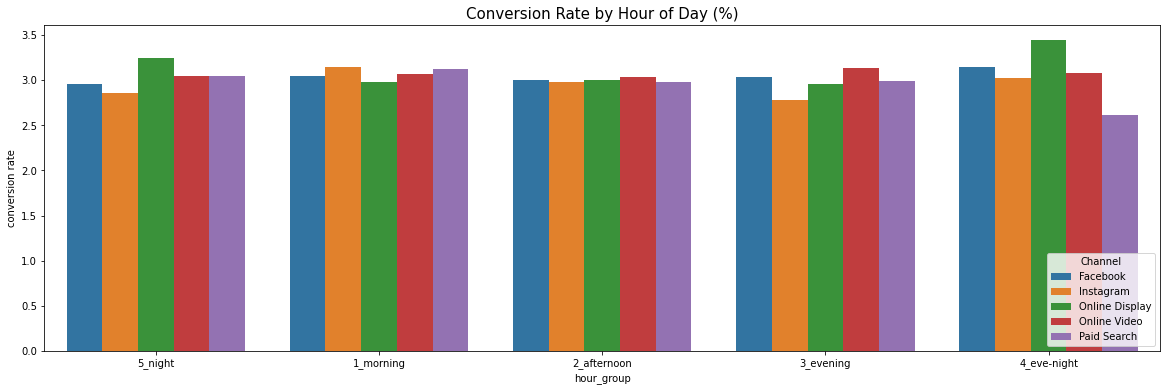

In [129]:
ch_con = round((df[df['conversion']==1].groupby(['channel','hour_group']).size()*100/df.groupby(['channel','hour_group']).size()),2).reset_index(name = 'conversion rate')
ax = sns.barplot(hue='channel', y='conversion rate', x='hour_group', data=ch_con)
ax.set_title("Conversion Rate by Hour of Day (%)", size=15)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0), title='Channel')

ax.figure.set_size_inches(20, 6)

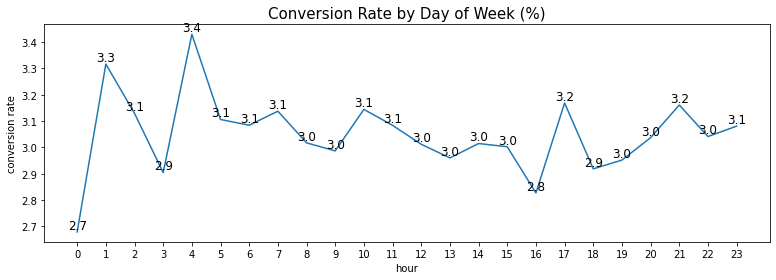

In [115]:
hour = (df[df['conversion']==1].groupby(['hour']).size()*100/df.groupby(['hour']).size()).reset_index(name = 'conversion rate')

ax = sns.lineplot(x=hour.hour, y='conversion rate', data=hour, color=colors)
ax.set_title("Conversion Rate by Day of Week (%)", size=15)
ax.figure.set_size_inches(13, 4)
for x, y in zip(hour.hour, hour['conversion rate']):
    ax.text(x, y, f'{y:.1f}', ha='center', va='bottom', size=12)
ax.set_xticks(hour.hour) 
ax.set_xticklabels(hour.hour)
plt.show()

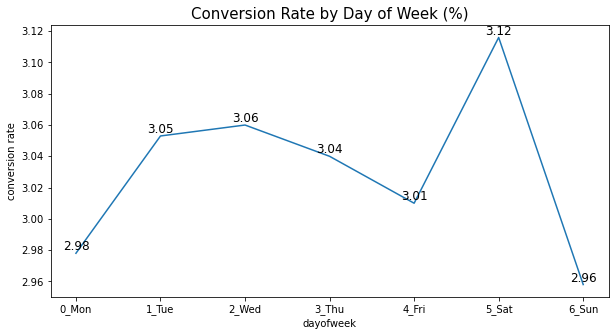

In [110]:
dow = round((df[df['conversion']==1].groupby(['dayofweek']).size()*100/df.groupby(['dayofweek']).size()),3).reset_index(name = 'conversion rate')

ax = sns.lineplot(x=dow.dayofweek, y='conversion rate', data=dow, color=colors)
ax.set_title("Conversion Rate by Day of Week (%)", size=15)
ax.figure.set_size_inches(10, 4)

for x, y in zip(dow.dayofweek, dow['conversion rate']):
    ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=12)
plt.show()

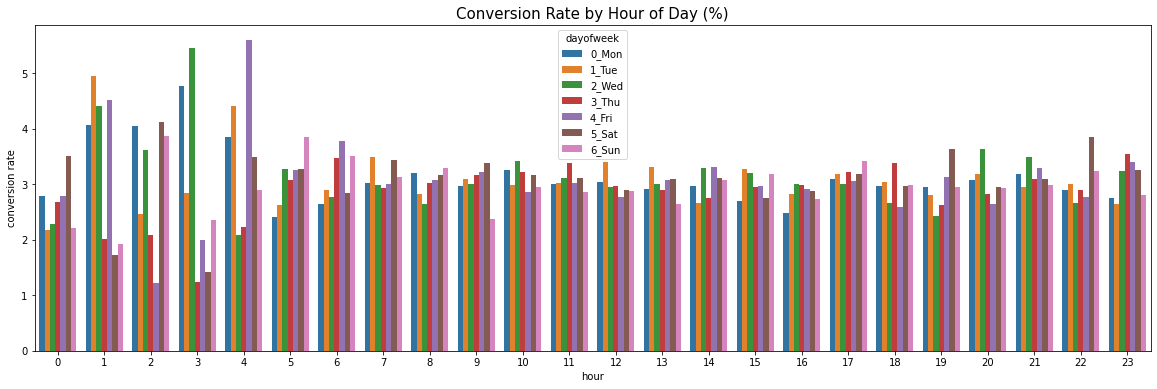

In [121]:
hour = (df[df['conversion']==1].groupby(['dayofweek','hour']).size()*100/df.groupby(['dayofweek','hour']).size()).reset_index(name = 'conversion rate')
ax = sns.barplot(x='hour', y='conversion rate', hue='dayofweek', data=hour)
ax.set_title("Conversion Rate by Hour of Day (%)", size=15)
ax.figure.set_size_inches(20, 6)

In [ ]:
# 내가 알고 싶은건. 채널별로 가장 주목을 얻는 채널과 (자주 들어오게 되는 채널) 그 중 실제로 구매로 이어지게 하는 채널.
# 근데 사람으로도 함께 봐도 좋을 것 같다. 만약 주목을 많이 끄는 반면에 실구매자의 

ch_con = df.groupby('channel').size().reset_index(name = 'total_visit').sort_values(by = 'total_visit', ascending = False)
# 즉 채널별 접속 횟수와 구매 횟수.

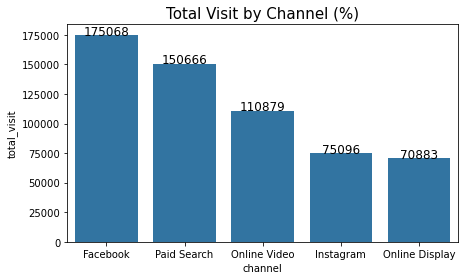

In [131]:
## total visit per channel, time, day of week? (한 사람이 야러번 들어오면 여러번 카운트)

ch_con = df.groupby('channel').size().reset_index(name = 'total_visit').sort_values(by = 'total_visit', ascending = False)

colors = sns.color_palette()[0]
ax = sns.barplot(x = ch_con.channel, y = 'total_visit', data = ch_con, color = colors)
ax.set_title("Total Visit by Channel (%)", size = 15)
ax.figure.set_size_inches(7,4)
for bar, label in zip(ax.patches, ch_con['total_visit']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x+width/2., height, label, ha="center", size=12) ;

In [ ]:
## actual customers per channel, time, day of week?


In [ ]:
## 구매자 percentage per channel, time, day of week?

In [ ]:
# conversion rate over time

In [ ]:
## how many visit is completed before the 1st purchase? histrogram

In [ ]:
## purchase amount histrogram

In [ ]:
# 1. Cohort by acquisition date - how much is avg purchase amount, total number of visitors and conversion rate per cohort?

In [ ]:
# 2. Cohort by hour 

In [ ]:
# 3. Cohort by day of week

<a id='cross_channel'></a>
## Cross-Channel Interaction

In [267]:
# df[df['conversion']==1]
df[df['cookie']=='ooonih0kon3FDAB90EfADEFnn']

,cookie,time,interaction,conversion,conversion_value,channel,channel_sequence,attribution_validity,within_window
586722,ooonih0kon3FDAB90EfADEFnn,2018-07-13 08:43:38+00:00,impression,0,0.0,Facebook,Online Video,2018-08-10 08:43:38+00:00,True
586723,ooonih0kon3FDAB90EfADEFnn,2018-07-13 09:35:35+00:00,conversion,1,7.5,Instagram,Instagram,2018-08-10 09:35:35+00:00,True


In [1]:
# conversion rate per route (paid -> facebook)

df['channel_order'] = df.sort_values('time').groupby('cookie').cumcount() + 1
df_order = df.groupby('cookie')['channel'].apply(list).reset_index(name='channel_order')
df_last_int = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_value']]
df_order = pd.merge(df_order, df_last_int, on='cookie', how='left')

df_order['channel_order'] = df_order['channel_order'].apply(' - '.join)
df_order.drop(columns=['cookie'], inplace=True)

df_order['null'] = np.where(df_order['conversion'] == 0, 1, 0)

attribution_df = df_order.groupby('channel_order').agg(
    total_conversions=('conversion', 'sum'),
    total_null=('null', 'sum'),
    total_conversion_value=('conversion_value', 'sum')).reset_index()

NameError: name 'df' is not defined

In [15]:
attribution_df

,channel_order,total_conversions,total_null,total_conversion_value
0,Facebook,2054,32852,12857.0
1,Facebook - Facebook,540,7388,3306.0
2,Facebook - Facebook - Facebook,230,2055,1458.5
3,Facebook - Facebook - Facebook - Facebook,84,739,536.0
4,Facebook - Facebook - Facebook - Facebook - Fa...,40,317,250.5
...,...,...,...,...
11304,Paid Search - Paid Search - Paid Search - Paid...,1,0,6.0
11305,Paid Search - Paid Search - Paid Search - Paid...,0,1,0.0
11306,Paid Search - Paid Search - Paid Search - Paid...,0,1,0.0
11307,Paid Search - Paid Search - Paid Search - Paid...,0,1,0.0


In [17]:
# heatmap

transition_matrix = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")

matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)
 
matrix

The 'cookie' column is not present in the DataFrame.


KeyError: 'cookie'

## Attribution Modeling

In [261]:
# step 1. deciding attribution window for each channel.

df['time'] = pd.to_datetime(df['time'])
successful_conversions = df[df['conversion'] == 1]

attribution_windows = {
    'Instagram': timedelta(days=28),
    'Online Display': timedelta(days=28),
    'Paid Search': timedelta(days=28),
    'Facebook': timedelta(days=28),
    'Online Video': timedelta(days=28)}

# I assigned 28 days to all channels, based on Facebook's attribution window value of 28 days for clicks 

def assign_attribution_window(row):
    interaction_time = row['time']
    channel = row['channel']
    attribution_window = attribution_windows[channel]
    attribution_start_time = interaction_time + attribution_window
    return attribution_start_time

df['attribution_validity'] = df.apply(assign_attribution_window, axis=1)

conversion_times = df.loc[df['conversion'] == 1, ['cookie', 'time']].groupby('cookie').min()
merged_df = pd.merge(df, conversion_times, on='cookie', suffixes=('', '_conv'))
filtered_rows = merged_df[merged_df['attribution_validity'] >= merged_df['time_conv']]

df['within_window'] = df.cookie.isin(filtered_rows.cookie)
df.head()


# this is to use attribution windows that we calculated earlier, for single & multi touch

,cookie,time,interaction,conversion,conversion_value,channel,channel_sequence,attribution_validity,within_window
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,,2018-07-31 13:02:11+00:00,False
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,,2018-08-14 19:15:07+00:00,False
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,,2018-08-21 15:51:46+00:00,False
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,,2018-08-26 07:44:51+00:00,False
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,,2018-07-31 09:44:57+00:00,False


In [ ]:
# step 2. Last Click Model 
# For non-data-driven attribution model, I'm going to use Last click model, which is most commonly used in many tracking tools


In [ ]:
# step 3. Data Driven Attribution Model 
# I'm going to use Markov Chain analysis by using univariate logistic regression

In [ ]:
# step 4. Compare

In [ ]:
# What did I learn from this project, and how did I learn? 
# learned from marketing blogs (e.g.hubspot), kaggle notebook to see expected output
# in terms of tricky coding, asked for a help to colleagues

In [ ]:
# thought process